# Simulation modeling

Some systems in math modeling have to be studied using simulations, either because it might be impossible to do an experiment to measure the system, because the system can't be studied analytically, or many other reasons. Simulation is one of the most important tools in math modeling, because it allows one to study a system even without having access to it experimentally.

One can still use past data to inform a simulation model. Let's go through a real world example where we can use simulation modeling to study how a system behaves. This system is discussed in section 5.4.

## Inventory model for gasoline and consumer demand

The goal in this example is, for a chain of gas stations, to determine how often and how much gas to deliver to their stations. Let's look at how many gallons were demanded at a single gas station over a period of 1000 days. We will use this as a prototype to simulate the gas station demand. The information we have is a range of gallons demanded at the station and the number of times that demand occurred.

| Number of gallons demanded | Number of occurrences (in days) |
|---|---|
|1000-1099|10|
|1100-1199|20|
|1200-1299|50|
|1300-1399|120|
|1400-1499|200|
|1500-1599|270|
|1600-1699|180|
|1700-1799|80|
|1800-1899|40|
|1900-1999|30|

Let's turn this into something that can be graphed. Later we will use this information to generate simulations of demand for a hypothetical station.

As a simplistic assumption, say that the amount demanded in each occurrence was the center of the bin. So 10 days with demand from 1000-1099 translates to 10 days with demand of 1050 gallons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
demand_amts = [1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950]
demand_occs = [10,20,50,120,200,270,180,80,40,30]
nbins = len(demand_occs)
ndays = np.sum(demand_occs) # total number of days

demand_raw = []
for i in range(0, nbins):
    demand_raw.extend([demand_amts[i]]*demand_occs[i])
demand_raw = np.asarray(demand_raw) # make it a numpy array
# print(demand_raw)
print('Check length of demand data array: ', len(demand_raw))

Check length of demand data array:  1000


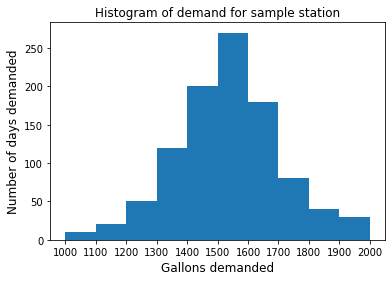

In [3]:
demand_bins = [1000,1100,1200,1300,1400,1500,1600,1700,1800, 1900, 2000]
plt.hist(demand_raw, demand_bins);
plt.xticks([1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000])
plt.xlabel('Gallons demanded', fontsize=12)
plt.ylabel('Number of days demanded', fontsize=12)
plt.title('Histogram of demand for sample station', fontsize=12);

This is a representation of the data set we have been provided by the company. Now we need a way to use this to address the problem at hand: 

**How does the company determine how much and how often to deliver gas to the different stations?**

We need to make some assumptions and translate this into a specific mathematical problem. 

Let's start with the simplest assumptions possible to create our simulation.

- consider deliveries to a single station only
- assume demand approximately follows the historical data for the sample station
- try to minimize the total costs associated with the station
- look at cost daily because provided data is daily demand
- aim to **minimize average daily cost of delivering and storing sufficient gas at each station to meet consumer demand**

Let's break down the costs and set up other assumptions

- let $Q$ be the gallons of gas delivered in a given day, and assume it's always the same amount every day.
- assume a constant cost $d$ for delivery that doesn't change with amount of gas delivered. $d$ = delivery cost per delivery per day
- other costs: storage of unused gas, wear and tear on delivery equipment which would increase with more deliveries
- assume constant cost per unit associated with storage of extra gas $s$ = cost of storage per gallon per day
- the demand in gallons per day is $r$
- Let the cost each day be $c$ which will be the sum of the delivery and storage charges (and could be expanded if the cost model becomes more complicated)
- Let $C = \frac{1}{N}\sum_{i=1}^N c_i $ be the average daily cost over a period of $N$ days. 

This is going to be a fairly complicated model

$$ C = f(Q, s, r, d) $$

Writing this down analytically would be challenging, but probably it is impossible to do. Let's think instead about varying the inputs to $f$ and simulating what $C$ is at different values of the inputs.

## Simulating the average daily cost

We can set and experiment with different values of $s$, $d$, and $Q$ over the period of $N$ days since we assumed they don't change from day to day. However, the data we have from before shows that $r$ changes depending on the day and is not constant. This is the quantity we will have to be the most careful with which setting up our model.

### Creating a "demand generator" from historical data

Our goal is to generate a simulation of demand at our hypothetical gas station using the historical data from before.

We can treat this like a probability distribution and say that it represents the probability out of a long run of days that a demand of that amount will occur.

| Number of gallons demanded | Number of occurrences (in days) | Probability of occurrence |
|---|---|---|
|1000-1099|10|0.01|
|1100-1199|20|0.02|
|1200-1299|50|0.05|
|1300-1399|120|0.12|
|1400-1499|200|0.20|
|1500-1599|270|0.27|
|1600-1699|180|0.18|
|1700-1799|80|0.08|
|1800-1899|40|0.04|
|1900-1999|30|0.03|

One thing we can do with this data set is to consider the cumulative probability $CP(r)$ from $r = 1000$ to $r=2000$.

| Number of gallons demanded | Probability of occurrence |Cumulative probability|
|---|---|---|
|1000-1099|0.01|0.01|
|1100-1199|0.02|0.03|
|1200-1299|0.05|0.08|
|1300-1399|0.12|0.20|
|1400-1499|0.20|0.40|
|1500-1599|0.27|0.67|
|1600-1699|0.18|0.85|
|1700-1799|0.08|0.93|
|1800-1899|0.04|0.97|
|1900-1999|0.03|1.00|

In [4]:
CP_demand = np.array([0.00,0.01,0.03,0.08,0.20,0.40,0.67,0.85,0.93,0.97,1.00])

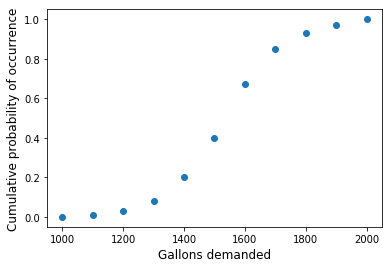

In [5]:
plt.plot(demand_bins, CP_demand, 'o')
plt.xlabel('Gallons demanded', fontsize=12)
plt.ylabel('Cumulative probability of occurrence', fontsize=12);

If we think about generating a random number in the range $x$ from 0 to 1, we can use where that number lands to determine which demand bin to use. Think about reversing the axes of this graph

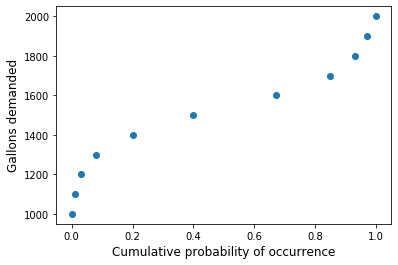

In [6]:
plt.plot(CP_demand, demand_bins, 'o')
plt.ylabel('Gallons demanded', fontsize=12)
plt.xlabel('Cumulative probability of occurrence', fontsize=12);

Pick a random number on the x axis, and then figure out what $r$ is for that number. The problem is that we don't have $r$ values on the above graph for all the different $x = CP(r)$ values. So we use some sort of model, let's say splines, to connect the dots here.

In [7]:
from scipy.interpolate import interp1d

In [8]:
demand_generator = interp1d(CP_demand, demand_bins, kind="cubic")

In [9]:
n_x_vals = 100
x_vals = np.linspace(0,1,num=n_x_vals)
predicted_r = demand_generator(x_vals)

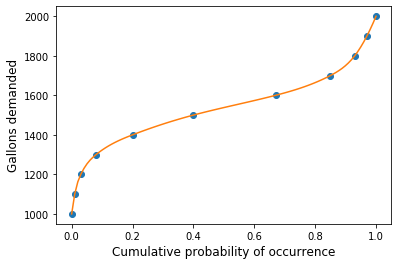

In [10]:
plt.plot(CP_demand, demand_bins, 'o')
plt.plot(x_vals, predicted_r, '-')
plt.ylabel('Gallons demanded', fontsize=12)
plt.xlabel('Cumulative probability of occurrence', fontsize=12);

This is going to be our demand generating function. The procedure is to

1. Generate a random number from $x=0$ to $x=1$. 
2. Use that random number as an input to the `spline` function generated above
3. Use the output number as the demand from that day.
4. Repeat for as many days as you would like to simulate.

### Using the demand generator

Let's put the above steps into action and generate demand for out hypothetical station for some number of days, say $N=10$. 

In [11]:
np.random.seed(1) # make sure random numbers are same every time you run the notebook
N_days = 10
random_x_vals = np.random.random(N_days)
print(random_x_vals)

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]


Those are our 10 random $x$ values. Let's use the spline demand generator to translate these into an amount of gasoline demanded.

In [12]:
random_r_vals = demand_generator(random_x_vals)

In [13]:
print(random_r_vals)

[1506.89277534 1621.37003761 1001.42121955 1455.72189488 1365.07029761
 1314.71008681 1391.71006703 1476.34250967 1498.66492751 1551.76941003]


This is a list of 10 randomly generated demand amounts from historical data. We'll generally study this type of data by histogramming it to see what it looks like.

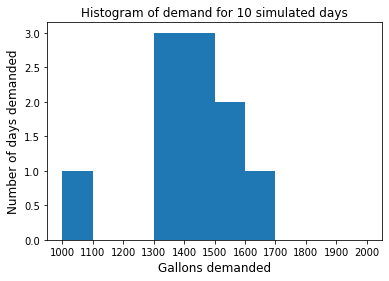

In [14]:
plt.hist(random_r_vals, demand_bins);
plt.xticks([1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000])
plt.xlabel('Gallons demanded', fontsize=12)
plt.ylabel('Number of days demanded', fontsize=12)
plt.title('Histogram of demand for 10 simulated days', fontsize=12);

Let's try a greater number of days, say 100 and see how the histogram looks.

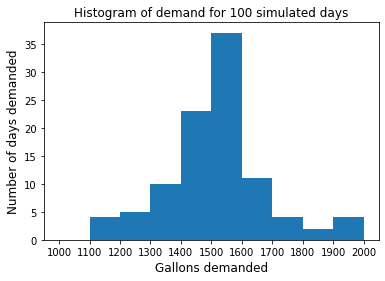

In [15]:
np.random.seed(2) # change the seed to get different random numbers
N_days_2 = 100
random_x_vals_2 = np.random.random(N_days_2)
random_r_vals_2 = demand_generator(random_x_vals_2)
plt.hist(random_r_vals_2, demand_bins);
plt.xticks([1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000])
plt.xlabel('Gallons demanded', fontsize=12)
plt.ylabel('Number of days demanded', fontsize=12)
plt.title('Histogram of demand for 100 simulated days', fontsize=12);

This actually looks closer to the original histogram of the historical data. The more days we simulate, the closer it will look to the historical data histogram.

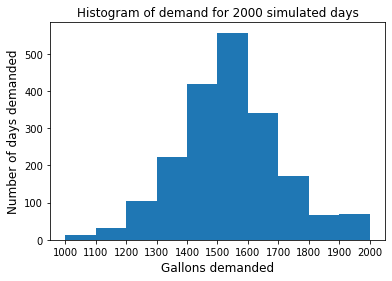

In [16]:
np.random.seed(3) # change the seed to get different random numbers
N_days_3 = 2000
random_x_vals_3 = np.random.random(N_days_3)
random_r_vals_3 = demand_generator(random_x_vals_3)
plt.hist(random_r_vals_3, demand_bins);
plt.xticks([1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000])
plt.xlabel('Gallons demanded', fontsize=12)
plt.ylabel('Number of days demanded', fontsize=12)
plt.title('Histogram of demand for 2000 simulated days', fontsize=12);

## Simulating the station

Now we have our demand generator from historical data `demand_generator`. We can now use it to simulate demand over a period of many days. 

Now we need to simulate the station over a series of $N$ days. Assume a quantity $Q$ is delivered each day and it costs $d$ dollars for the delivery. Use the amount of gasoline demanded that day $r$ and subtract that amount from $Q$ to determine how much gas needs to be stored and how much it would cost. If demand was greater than $r$, then set the remaining amount of gas to 0. Multiply $Q - r$ by $s$ to compute the storage cost.

In [20]:
N_days_simulate = 20 # simulate 20 days
np.random.seed(234) # 
random_x_vals_simulate = np.random.random(N_days_simulate)
random_r_vals_simulate = demand_generator(random_x_vals_simulate)

Now we have the demand amounts for each day of the simulation. Let's set up different delivery quantities, delivery costs, and storage costs. These are all assumptions and can be changed. Let's start by assuming

- $s = \$0.01$  per gallon per day
- $d = \$100$ per day
- $Q = 1500$ gallons per day
- $r$ for each days comes from the list above

In [21]:
s_cost = 0.01
d_cost = 100
Q_amt = 1500

Use a for loop to simulate the 20 days

In [39]:
daily_cost = np.empty(N_days_simulate) # array to hold the cost for each day
gas_stored = 0.0 # variable to hold the amount of gas in storage

for i in range(0, N_days_simulate):
    print('>> Day',i+1,'begins')
    print('> Truck delivery arrives in the amount of', Q_amt, 'gallons')
    print('> Delivery cost incurred today: $', d_cost)
    # add the delivery amount onto the stored gas amount
    gas_stored += Q_amt
    todays_demand = random_r_vals_simulate[i]
    print('> The demand today is', '{:.2f}'.format(todays_demand), 'gallons')
    gas_left = gas_stored - todays_demand
    if gas_left < 0: # the gas amount cannot go negative
        print('> ALERT! The station could not fulfill', '{:.2f}'.format(abs(gas_left)), 'gallons of demand today')
        gas_stored = 0.0
    else:
        gas_stored = gas_left
    print('> Amount of gas leftover at end of day:', '{:.2f}'.format(gas_stored))
    # compute the storage cost for the day
    storage_cost = gas_stored * s_cost
    print('> Storage cost incurred today:', '${:.2f}'.format(storage_cost))
    daily_cost[i] = storage_cost + d_cost
    print('> Cost incurred today:', '${:.2f}'.format(daily_cost[i]))
    print('>> Day', i+1, 'ends')
    print() # blank line for spacing
    

>> Day 1 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1203.11 gallons
> Amount of gas leftover at end of day: 296.89
> Storage cost incurred today: $2.97
> Cost incurred today: $102.97
>> Day 1 ends

>> Day 2 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1430.80 gallons
> Amount of gas leftover at end of day: 366.09
> Storage cost incurred today: $3.66
> Cost incurred today: $103.66
>> Day 2 ends

>> Day 3 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1768.67 gallons
> Amount of gas leftover at end of day: 97.42
> Storage cost incurred today: $0.97
> Cost incurred today: $100.97
>> Day 3 ends

>> Day 4 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1900.52 gallons
> ALERT! The station co

In [42]:
print(np.average(daily_cost))

100.50502723887402


The average daily cost is \$100.51 from this 20 day simulation.

The station could obviously save on costs if they never have any gas left at the end of the day. But then people might stop coming to the station and the station won't make any revenue. So let's adjust our model a bit to also consider the number of days that demand is not fulfilled.

In [40]:
daily_cost = np.empty(N_days_simulate) # array to hold the cost for each day
gas_stored = 0.0 # variable to hold the amount of gas in storage
n_days_unfulfilled = 0

for i in range(0, N_days_simulate):
    print('>> Day',i+1,'begins')
    print('> Truck delivery arrives in the amount of', Q_amt, 'gallons')
    print('> Delivery cost incurred today: $', d_cost)
    # add the delivery amount onto the stored gas amount
    gas_stored += Q_amt
    todays_demand = random_r_vals_simulate[i]
    print('> The demand today is', '{:.2f}'.format(todays_demand), 'gallons')
    gas_left = gas_stored - todays_demand
    if gas_left < 0: # the gas amount cannot go negative
        print('> ALERT! The station could not fulfill', '{:.2f}'.format(abs(gas_left)), 'gallons of demand today')
        gas_stored = 0.0
        n_days_unfulfilled += 1
    else:
        gas_stored = gas_left
    print('> Amount of gas leftover at end of day:', '{:.2f}'.format(gas_stored))
    # compute the storage cost for the day
    storage_cost = gas_stored * s_cost
    print('> Storage cost incurred today:', '${:.2f}'.format(storage_cost))
    daily_cost[i] = storage_cost + d_cost
    print('> Cost incurred today:', '${:.2f}'.format(daily_cost[i]))
    print('>> Day', i+1, 'ends')
    print() # blank line for spacing

>> Day 1 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1203.11 gallons
> Amount of gas leftover at end of day: 296.89
> Storage cost incurred today: $2.97
> Cost incurred today: $102.97
>> Day 1 ends

>> Day 2 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1430.80 gallons
> Amount of gas leftover at end of day: 366.09
> Storage cost incurred today: $3.66
> Cost incurred today: $103.66
>> Day 2 ends

>> Day 3 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1768.67 gallons
> Amount of gas leftover at end of day: 97.42
> Storage cost incurred today: $0.97
> Cost incurred today: $100.97
>> Day 3 ends

>> Day 4 begins
> Truck delivery arrives in the amount of 1500 gallons
> Delivery cost incurred today: $ 100
> The demand today is 1900.52 gallons
> ALERT! The station co

In [41]:
print(n_days_unfulfilled)

12


So there were 12 days in the simulation where the demand was not fulfilled.

## Creating a simulation function

It is not very convenient to have to copy and paste all of this every time we want to perform the demand simulation. Let's create a function to encapsulate the code so we can easily change the inputs and turn off the day-by-day summary if necessary.

In [57]:
def simulate_station(N_in, Q_in, d_in, s_in, verbose=False):
    # verbose is an optional argument that can be set to true if you want to see all the output like above
    # it's impractical to use for a great number of days
    #np.random.seed(1)
    x_vals = np.random.random(N_in)
    daily_demand = demand_generator(x_vals)
    daily_cost = np.empty(N_in) # array to hold the cost for each day
    gas_stored = 0.0 # variable to hold the amount of gas in storage
    n_days_unf = 0

    for i in range(0, N_in):
        if verbose:
            print('>> Day',i+1,'begins')
            print('> Truck delivery arrives in the amount of', Q_amt, 'gallons')
            print('> Delivery cost incurred today: $', d_in)
        # add the delivery amount onto the stored gas amount
        gas_stored += Q_amt
        todays_demand = daily_demand[i]
        if verbose:
            print('> The demand today is', '{:.2f}'.format(todays_demand), 'gallons')
        gas_left = gas_stored - todays_demand
        if gas_left < 0: # the gas amount cannot go negative
            if verbose:
                print('> ALERT! The station could not fulfill', '{:.2f}'.format(abs(gas_left)), 'gallons of demand today')
            gas_stored = 0.0
            n_days_unf += 1
        else:
            gas_stored = gas_left
        if verbose:
            print('> Amount of gas leftover at end of day:', '{:.2f}'.format(gas_stored))
        # compute the storage cost for the day
        storage_cost = gas_stored * s_cost
        if verbose:
            print('> Storage cost incurred today:', '${:.2f}'.format(storage_cost))
        daily_cost[i] = storage_cost + d_in
        if verbose:
            print('> Cost incurred today:', '${:.2f}'.format(daily_cost[i]))
            print('>> Day', i+1, 'ends')
            print() # blank line for spacing
        
    avg_cost = np.average(daily_cost)
    return avg_cost, n_days_unf

In [63]:
simulate_station(100, 1500, 100, 0.01, verbose=False)

(103.01713964199479, 13)